In [1]:
# ===========================
# 1. IMPORTS & DRIVE MOUNT
# ===========================

!pip install -q ultralytics torchsummary

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

from tqdm import tqdm
from IPython.display import display

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda


In [2]:
# =========================================
# 2. LOAD & ADAPT PRETRAINED YOLOv8s-CLS
# =========================================

from ultralytics import YOLO

# Load classification model (v8.0 checkpoint)
hub_model = YOLO('yolov8s-cls.pt').to(device)
hub_model.model.eval()
print("YOLOv8s-CLS loaded.")

# Inspect and replace final 1 000→4 linear head
classify_block = hub_model.model.model[-1]
in_features    = classify_block.linear.in_features
print(f"Original head: in_features={in_features}, out_features={classify_block.linear.out_features}")
classify_block.linear = nn.Linear(in_features, 4).to(device)

# Extract pure nn.Sequential for summary
classifier = hub_model.model.model.to(device)
summary(classifier, input_size=(3, 224, 224))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 12.3M/12.3M [00:00<00:00, 79.7MB/s]


YOLOv8s-CLS loaded.
Original head: in_features=1280, out_features=1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
              SiLU-4         [-1, 32, 112, 112]               0
              SiLU-5         [-1, 32, 112, 112]               0
              SiLU-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
              SiLU-8         [-1, 32, 112, 112]               0
              SiLU-9         [-1, 32, 112, 112]               0
             SiLU-10         [-1, 32, 112, 112]               0
             SiLU-11         [-1, 32, 112, 112]               0
             SiLU-12         [-1, 32, 112, 112]               0
             SiLU-13         [-1

In [3]:
# ===============================
# 3. DATA LOADING & TRANSFORMS
# ===============================

base_dir   = "/content/drive/MyDrive/spectrograms_split"
train_dir  = os.path.join(base_dir, "train")
val_dir    = os.path.join(base_dir, "val")
test_dir   = os.path.join(base_dir, "test")
bal_dir    = os.path.join(base_dir, "test_balanced")

for path in [train_dir, val_dir, test_dir, bal_dir]:
    assert os.path.isdir(path), f"Missing directory: {path}"

# ImageNet-style transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Datasets & DataLoaders
train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)
bal_ds   = datasets.ImageFolder(bal_dir,   transform=transform)

print("Classes:", train_ds.classes)
n_classes = len(train_ds.classes)

bs, nw = 32, 2
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=nw)
val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=nw)
test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=nw)
bal_loader   = DataLoader(bal_ds,   batch_size=bs, shuffle=False, num_workers=nw)

Classes: ['mild', 'moderate', 'normal', 'severe']


In [4]:
# ======================================
# 4. TRAINABLE PARAMETERS & OPTIMIZER
# ======================================

# Fine-tune entire network
for p in classifier.parameters():
    p.requires_grad = True

criterion    = nn.CrossEntropyLoss()
optimizer    = torch.optim.Adam(classifier.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [5]:
# ======================
# 5. TRAIN & VALIDATE
# ======================

num_epochs = 20
for epoch in range(num_epochs):
    # Train
    classifier.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]"):
        imgs, labels = imgs.to(device), labels.to(device)
        raw_out = classifier(imgs)
        outputs = raw_out[0] if isinstance(raw_out, tuple) else raw_out
        loss    = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train = running_loss / len(train_loader)
    print(f"Epoch {epoch+1:2d} TRAIN Loss: {avg_train:.4f}")
    lr_scheduler.step()

    # Validate
    classifier.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]"):
            imgs, labels = imgs.to(device), labels.to(device)
            raw_out = classifier(imgs)
            outputs = raw_out[0] if isinstance(raw_out, tuple) else raw_out
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    avg_val = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1:2d} VAL Loss: {avg_val:.4f} | VAL Acc: {val_acc:.2f}%\n")

print("Training complete.")

Epoch 1/20 [TRAIN]: 100%|██████████| 453/453 [25:07<00:00,  3.33s/it]


Epoch  1 TRAIN Loss: 1.0390


Epoch 1/20 [VAL]: 100%|██████████| 97/97 [06:36<00:00,  4.09s/it]


Epoch  1 VAL Loss: 1.1494 | VAL Acc: 63.53%



Epoch 2/20 [TRAIN]: 100%|██████████| 453/453 [03:46<00:00,  2.00it/s]


Epoch  2 TRAIN Loss: 0.6360


Epoch 2/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.02it/s]


Epoch  2 VAL Loss: 1.0416 | VAL Acc: 74.65%



Epoch 3/20 [TRAIN]: 100%|██████████| 453/453 [03:48<00:00,  1.98it/s]


Epoch  3 TRAIN Loss: 0.3331


Epoch 3/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.05it/s]


Epoch  3 VAL Loss: 0.9991 | VAL Acc: 76.17%



Epoch 4/20 [TRAIN]: 100%|██████████| 453/453 [03:49<00:00,  1.98it/s]


Epoch  4 TRAIN Loss: 0.1269


Epoch 4/20 [VAL]: 100%|██████████| 97/97 [00:48<00:00,  2.01it/s]


Epoch  4 VAL Loss: 0.9851 | VAL Acc: 75.72%



Epoch 5/20 [TRAIN]: 100%|██████████| 453/453 [03:45<00:00,  2.01it/s]


Epoch  5 TRAIN Loss: 0.0543


Epoch 5/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.02it/s]


Epoch  5 VAL Loss: 0.9869 | VAL Acc: 75.30%



Epoch 6/20 [TRAIN]: 100%|██████████| 453/453 [03:50<00:00,  1.97it/s]


Epoch  6 TRAIN Loss: 0.0288


Epoch 6/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.09it/s]


Epoch  6 VAL Loss: 0.9791 | VAL Acc: 75.81%



Epoch 7/20 [TRAIN]: 100%|██████████| 453/453 [03:49<00:00,  1.97it/s]


Epoch  7 TRAIN Loss: 0.0244


Epoch 7/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.07it/s]


Epoch  7 VAL Loss: 0.9805 | VAL Acc: 76.39%



Epoch 8/20 [TRAIN]: 100%|██████████| 453/453 [03:48<00:00,  1.98it/s]


Epoch  8 TRAIN Loss: 0.0315


Epoch 8/20 [VAL]: 100%|██████████| 97/97 [00:48<00:00,  2.00it/s]


Epoch  8 VAL Loss: 0.9727 | VAL Acc: 76.33%



Epoch 9/20 [TRAIN]: 100%|██████████| 453/453 [03:45<00:00,  2.01it/s]


Epoch  9 TRAIN Loss: 0.0284


Epoch 9/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.05it/s]


Epoch  9 VAL Loss: 0.9760 | VAL Acc: 75.75%



Epoch 10/20 [TRAIN]: 100%|██████████| 453/453 [03:49<00:00,  1.97it/s]


Epoch 10 TRAIN Loss: 0.0257


Epoch 10/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.09it/s]


Epoch 10 VAL Loss: 0.9756 | VAL Acc: 76.72%



Epoch 11/20 [TRAIN]: 100%|██████████| 453/453 [03:47<00:00,  1.99it/s]


Epoch 11 TRAIN Loss: 0.0125


Epoch 11/20 [VAL]: 100%|██████████| 97/97 [00:48<00:00,  2.00it/s]


Epoch 11 VAL Loss: 0.9613 | VAL Acc: 77.62%



Epoch 12/20 [TRAIN]: 100%|██████████| 453/453 [03:51<00:00,  1.96it/s]


Epoch 12 TRAIN Loss: 0.0082


Epoch 12/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.06it/s]


Epoch 12 VAL Loss: 0.9594 | VAL Acc: 77.94%



Epoch 13/20 [TRAIN]: 100%|██████████| 453/453 [03:48<00:00,  1.98it/s]


Epoch 13 TRAIN Loss: 0.0063


Epoch 13/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.06it/s]


Epoch 13 VAL Loss: 0.9629 | VAL Acc: 77.94%



Epoch 14/20 [TRAIN]: 100%|██████████| 453/453 [03:46<00:00,  2.00it/s]


Epoch 14 TRAIN Loss: 0.0039


Epoch 14/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.04it/s]


Epoch 14 VAL Loss: 0.9597 | VAL Acc: 78.14%



Epoch 15/20 [TRAIN]: 100%|██████████| 453/453 [03:47<00:00,  1.99it/s]


Epoch 15 TRAIN Loss: 0.0036


Epoch 15/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.07it/s]


Epoch 15 VAL Loss: 0.9584 | VAL Acc: 78.27%



Epoch 16/20 [TRAIN]: 100%|██████████| 453/453 [03:50<00:00,  1.97it/s]


Epoch 16 TRAIN Loss: 0.0034


Epoch 16/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.07it/s]


Epoch 16 VAL Loss: 0.9570 | VAL Acc: 78.14%



Epoch 17/20 [TRAIN]: 100%|██████████| 453/453 [03:48<00:00,  1.98it/s]


Epoch 17 TRAIN Loss: 0.0030


Epoch 17/20 [VAL]: 100%|██████████| 97/97 [00:48<00:00,  2.00it/s]


Epoch 17 VAL Loss: 0.9574 | VAL Acc: 77.88%



Epoch 18/20 [TRAIN]: 100%|██████████| 453/453 [03:47<00:00,  1.99it/s]


Epoch 18 TRAIN Loss: 0.0021


Epoch 18/20 [VAL]: 100%|██████████| 97/97 [00:47<00:00,  2.05it/s]


Epoch 18 VAL Loss: 0.9552 | VAL Acc: 78.56%



Epoch 19/20 [TRAIN]: 100%|██████████| 453/453 [03:49<00:00,  1.97it/s]


Epoch 19 TRAIN Loss: 0.0022


Epoch 19/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.10it/s]


Epoch 19 VAL Loss: 0.9561 | VAL Acc: 78.36%



Epoch 20/20 [TRAIN]: 100%|██████████| 453/453 [03:46<00:00,  2.00it/s]


Epoch 20 TRAIN Loss: 0.0020


Epoch 20/20 [VAL]: 100%|██████████| 97/97 [00:46<00:00,  2.07it/s]

Epoch 20 VAL Loss: 0.9549 | VAL Acc: 78.46%

Training complete.


In [6]:
# =====================================
# 6. TEST & BALANCED TEST EVALUATION
# =====================================

def evaluate(loader, title):
    classifier.eval()
    all_labels, all_preds, all_probs = [], [], []
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Evaluating {title}"):
            imgs, labels = imgs.to(device), labels.to(device)
            raw_out = classifier(imgs)
            outputs = raw_out[0] if isinstance(raw_out, tuple) else raw_out
            probs   = torch.softmax(outputs, dim=1)
            preds   = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()
    acc    = 100 * correct / total
    prec   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec    = recall_score   (y_true, y_pred, average='macro', zero_division=0)
    f1     = f1_score       (y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{title} Acc: {acc:.2f}%")
    print(f"{title} Prec (macro): {prec:.4f}")
    print(f"{title} Rec  (macro): {rec:.4f}")
    print(f"{title} F1   (macro): {f1:.4f}\n")
    print(f"{title} Per-class Report:\n", classification_report(
        y_true, y_pred,
        target_names=loader.dataset.classes,
        zero_division=0
    ))
    return y_true, y_pred, y_prob

# Test & Balanced Test
y_true_test, y_pred_test, y_prob_test = evaluate(test_loader, title="Test")
y_true_bal,  y_pred_bal,  y_prob_bal  = evaluate(bal_loader, title="Balanced Test")

Evaluating Test: 100%|██████████| 98/98 [06:41<00:00,  4.10s/it]



Test Acc: 79.46%
Test Prec (macro): 0.7841
Test Rec  (macro): 0.7683
Test F1   (macro): 0.7753

Test Per-class Report:
               precision    recall  f1-score   support

        mild       0.82      0.78      0.80      1262
    moderate       0.76      0.77      0.76       741
      normal       0.76      0.68      0.72       124
      severe       0.80      0.85      0.82       979

    accuracy                           0.79      3106
   macro avg       0.78      0.77      0.78      3106
weighted avg       0.79      0.79      0.79      3106



Evaluating Balanced Test: 100%|██████████| 13/13 [00:46<00:00,  3.56s/it]


Balanced Test Acc: 72.25%
Balanced Test Prec (macro): 0.7409
Balanced Test Rec  (macro): 0.7225
Balanced Test F1   (macro): 0.7247

Balanced Test Per-class Report:
               precision    recall  f1-score   support

        mild       0.64      0.72      0.68       100
    moderate       0.68      0.71      0.69       100
      normal       0.93      0.66      0.77       100
      severe       0.72      0.80      0.76       100

    accuracy                           0.72       400
   macro avg       0.74      0.72      0.72       400
weighted avg       0.74      0.72      0.72       400



In [9]:
# ====================================================
# 7. PLOTTING FUNCTIONS (Confusion Matrix, ROC, PR)
# ====================================================

# Global style & palette
sns.set_style("whitegrid")
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=0.8, as_cmap=True)

classes   = train_ds.classes
n_classes = len(classes)

# One-hot encodings
y_true_test_oh = np.eye(n_classes)[y_true_test]
y_true_bal_oh  = np.eye(n_classes)[y_true_bal]

def plot_confusion(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
    sns.heatmap(cm_norm, annot=cm, fmt="d", cmap=cmap,
                cbar_kws={'label':'Proportion (%)'},
                xticklabels=classes, yticklabels=classes, ax=ax)
    for i in range(n_classes):
        for j in range(n_classes):
            pct = cm_norm[i,j]*100
            ax.text(j+0.5, i+0.65, f"\n{pct:.1f}%",
                    ha="center", va="center", fontsize=8, color="black")
    ax.set_xlabel("Predicted Class"); ax.set_ylabel("True Class")
    ax.set_title(f"{title} Confusion Matrix")
    fig.tight_layout(); display(fig); plt.close(fig)

def plot_roc(y_true_oh, y_prob, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_oh[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=1.8, label=f"{cls} (AUC={roc_auc:.2f})")
    ax.plot([0,1],[0,1],'--',color='gray',linewidth=1)
    ax.set_xlim(-0.01,1.01); ax.set_ylim(-0.01,1.01)
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{title} ROC Curves"); ax.legend(loc="lower right", fontsize=8)
    fig.tight_layout(); display(fig); plt.close(fig)

def plot_pr(y_true_oh, y_prob, title):
    fig, ax = plt.subplots(figsize=(6,5), dpi=150)
    for i, cls in enumerate(classes):
        prec, rec, _ = precision_recall_curve(y_true_oh[:,i], y_prob[:,i])
        ap = average_precision_score(y_true_oh[:,i], y_prob[:,i])
        ax.plot(rec, prec, linewidth=1.8, label=f"{cls} (AP={ap:.2f})")
    ax.set_xlim(-0.01,1.01); ax.set_ylim(-0.01,1.01)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title(f"{title} Precision–Recall Curves")
    ax.legend(loc="lower left", fontsize=8)
    fig.tight_layout(); display(fig); plt.close(fig)

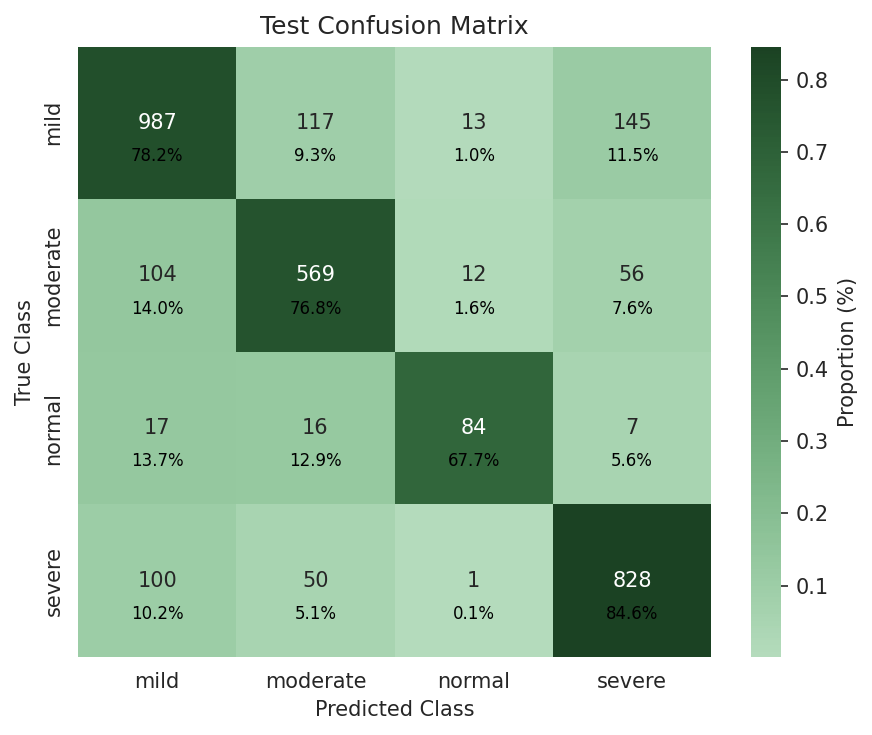

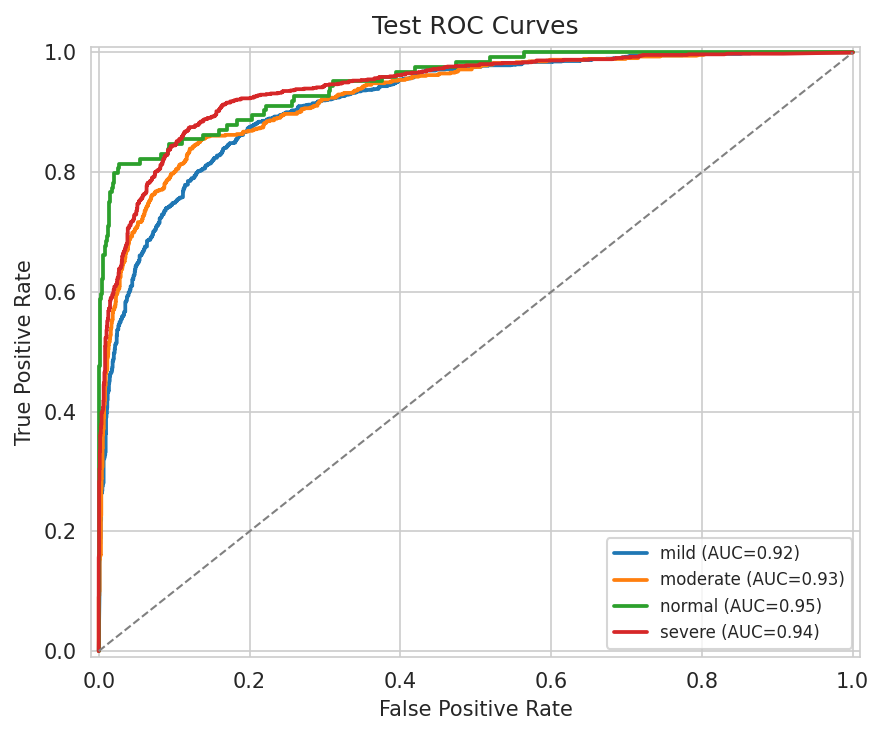

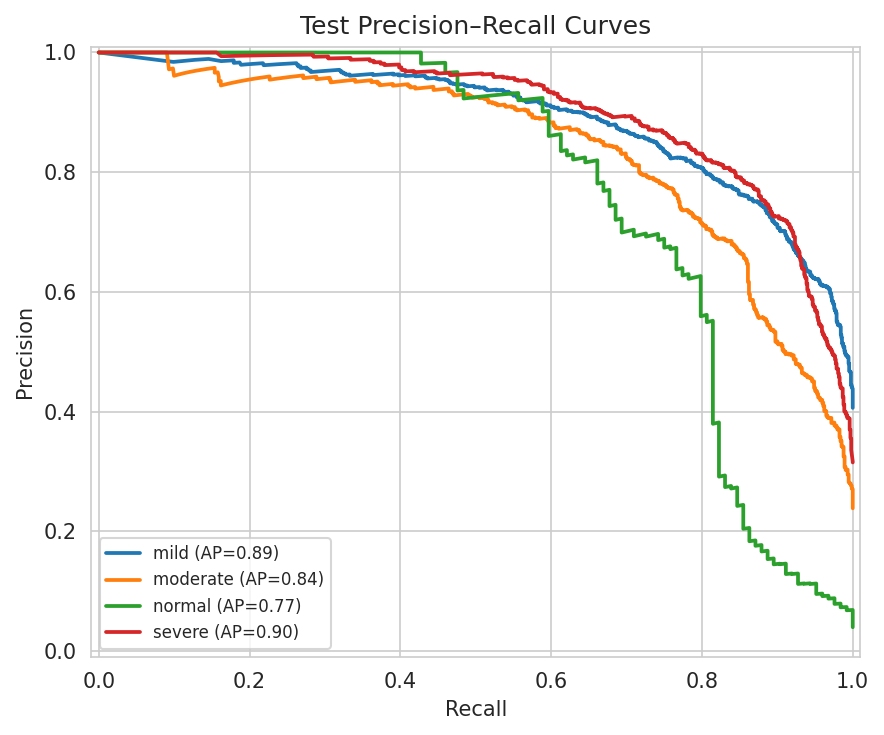

In [10]:
# ==========================
# 8. GENERATE ALL VISUALS
# ==========================

# Test set
plot_confusion(y_true_test,   y_pred_test,   title="Test")
plot_roc      (y_true_test_oh, y_prob_test,  title="Test")
plot_pr       (y_true_test_oh, y_prob_test,  title="Test")

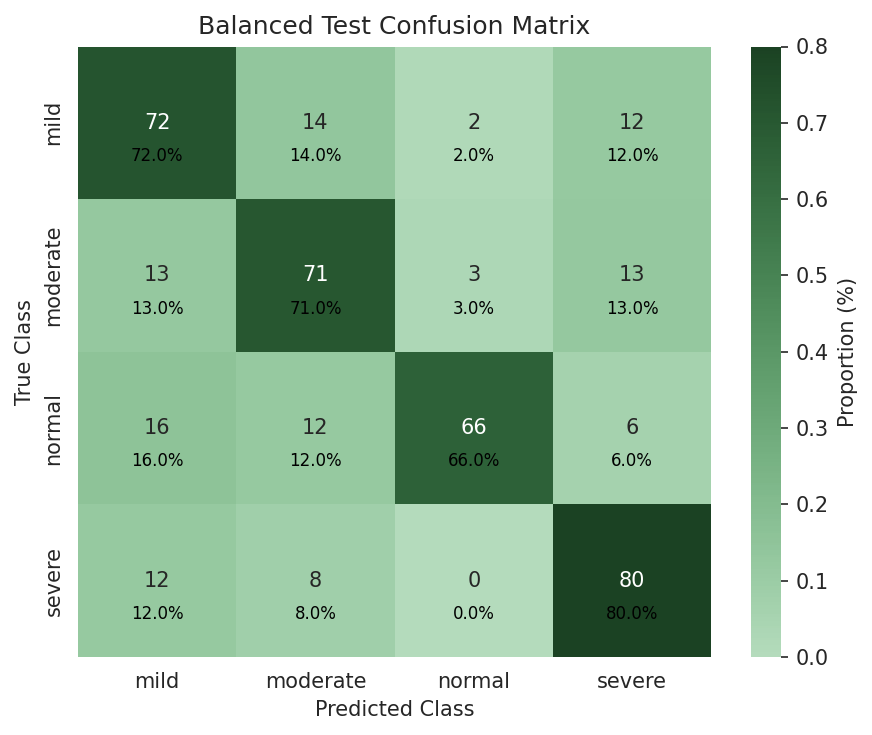

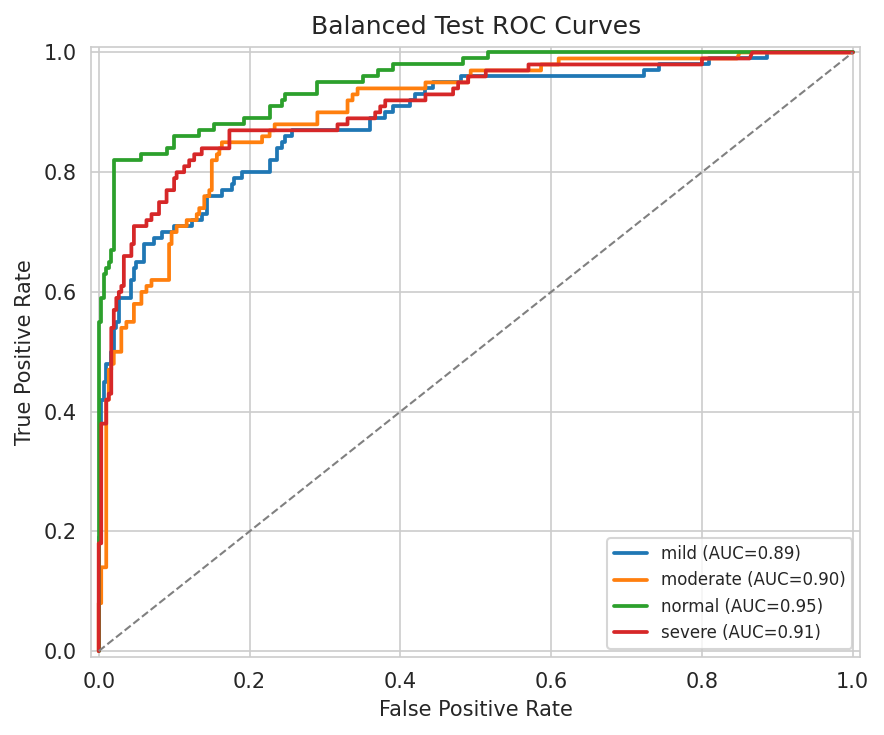

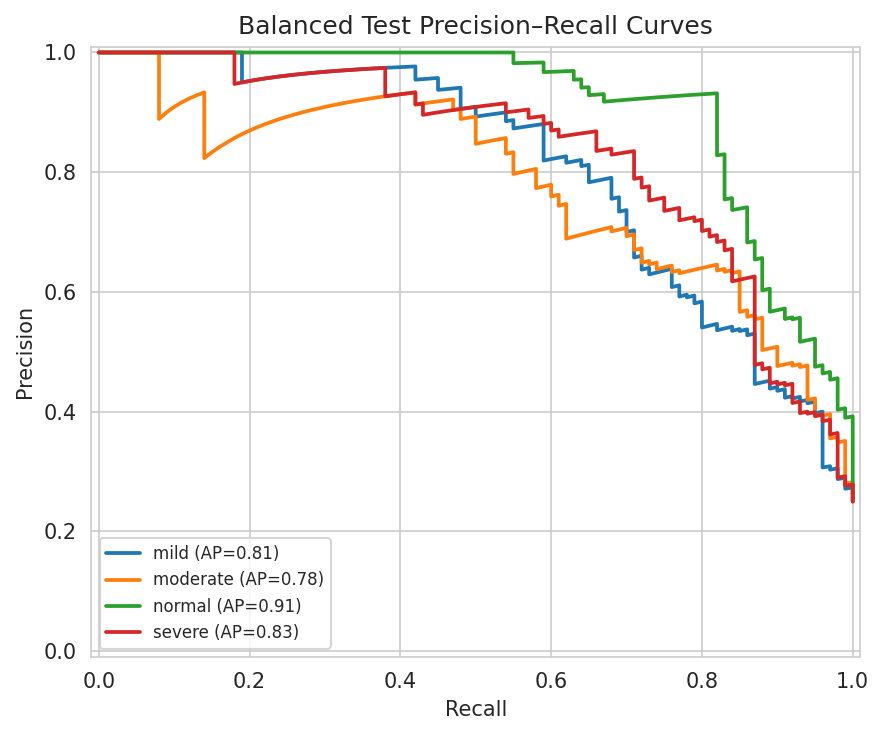

In [11]:
# Balanced Test set
plot_confusion(y_true_bal,    y_pred_bal,   title="Balanced Test")
plot_roc      (y_true_bal_oh,  y_prob_bal,   title="Balanced Test")
plot_pr       (y_true_bal_oh,  y_prob_bal,   title="Balanced Test")